# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [14]:
#Add panda options for column displays
#Print the long values in the columns
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = 150

### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

According to the *Materials and Methods* section of the referenced paper, the dataset represents the results of **17 direct marketing campaigns** conducted by a Portuguese banking institution between **May 2008 and November 2010**. These campaigns were phone-based and promoted an attractive long-term deposit product with competitive interest rates.

Across the 17 campaigns, a total of **79,354 contacts** were made. During each contact, various client details were recorded, including **job**, **marital status**, **education**, **housing loan**, and **personal loan** status, among others.

Out of all contacts made, **6,499 clients subscribed** to the term deposit, resulting in an overall **success rate of approximately 8%**. This highlights the challenge of client conversion and sets the stage for using machine learning to better identify the characteristics of clients likely to subscribe in future campaigns.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [16]:
bank = pd.read_csv('/Users/waelsultan/Desktop/AI-ML/Practical Application 3/module17_starter/data/bank-additional-full.csv', sep=';')


In [18]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [20]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



Let's begin with some exploratory data analysis to understand how certain features influence the output variable. For better readability in the visualizations, we'll rename the output variable. Our focus will primarily be on features 1 through 7, as these will form the basis for our modeling efforts.


In [24]:
# Change Y feature name to a more meaningful name
bank.rename(columns = {'y':'deposit'}, inplace = True)

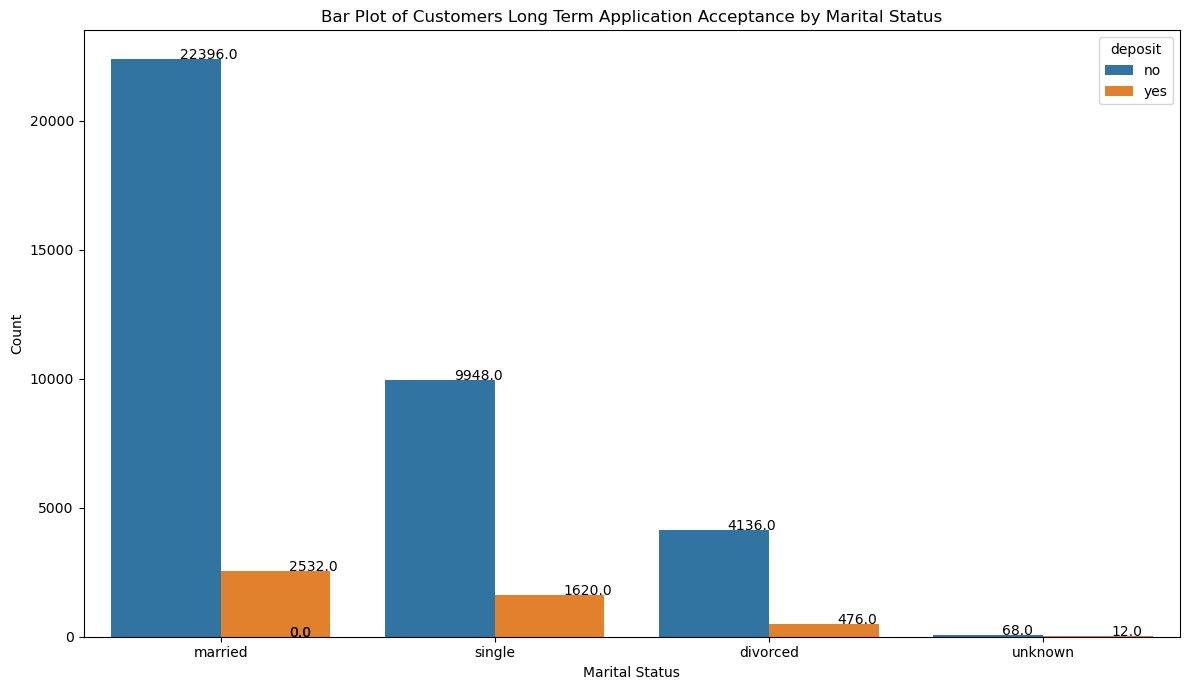

In [26]:
# Let plot a bar chart of the
# count plot on two categorical variable

plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.autolayout"] = True
ax = sns.countplot(x ='marital', hue = "deposit", data = bank)

# Adding Title to the Plot
ax.set_title('Bar Plot of Customers Long Term Application Acceptance by Marital Status')

for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

# Setting the X and Y labels
ax.set_xlabel('Marital Status')
ax.set_ylabel('Count')
 
# Show the plot
plt.show()

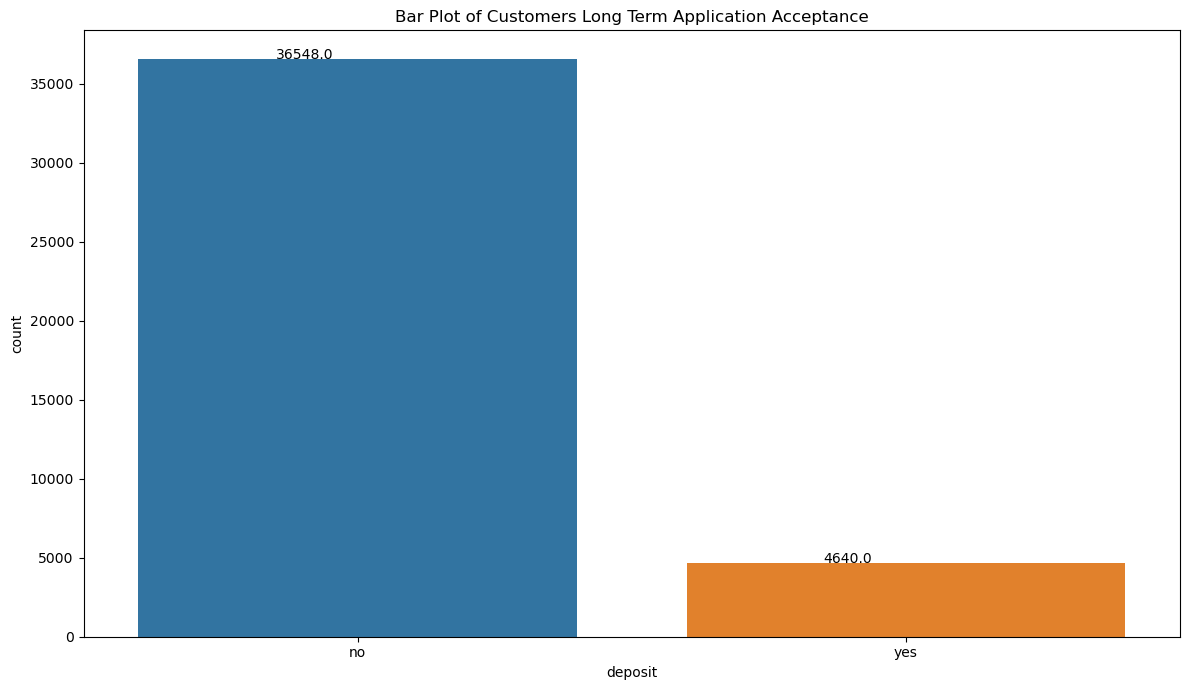

In [28]:
# Bar plot of customer count that said yes to term deposit vs no
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.autolayout"] = True

# count plot on two categorical variable
ax = sns.countplot(x ='deposit', hue = "deposit", data = bank)

# Adding Title to the Plot
ax.set_title('Bar Plot of Customers Long Term Application Acceptance')

for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
 
# Show the plot
plt.show()

In [30]:
#Clean data with no nulls
bank.isna().any()

age               False
job               False
marital           False
education         False
default           False
housing           False
loan              False
contact           False
month             False
day_of_week       False
duration          False
campaign          False
pdays             False
previous          False
poutcome          False
emp.var.rate      False
cons.price.idx    False
cons.conf.idx     False
euribor3m         False
nr.employed       False
deposit           False
dtype: bool

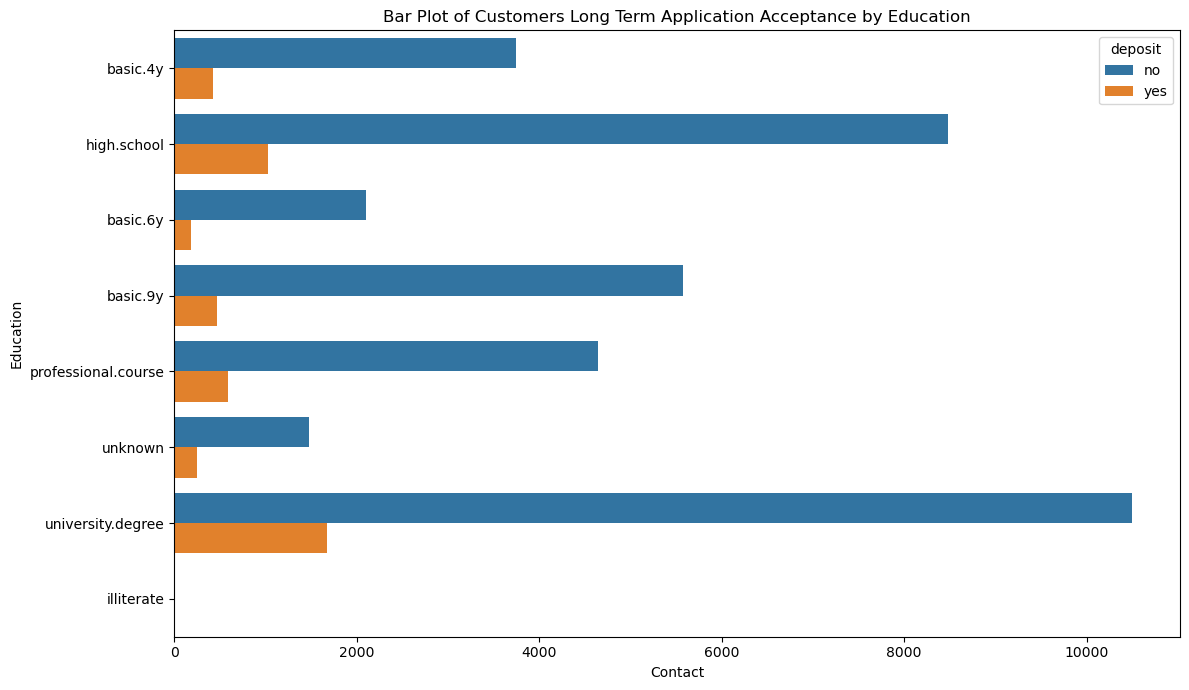

In [42]:
# Bar plot of count of accepted term deposit application by Education
ax = sns.countplot(y ='education', hue = "deposit", data = bank)

# Adding Title to the Plot
ax.set_title('Bar Plot of Customers Long Term Application Acceptance by Education')

# Setting the X and Y labels
ax.set_xlabel('Contact')
ax.set_ylabel('Education')

# Show the plot
plt.show()

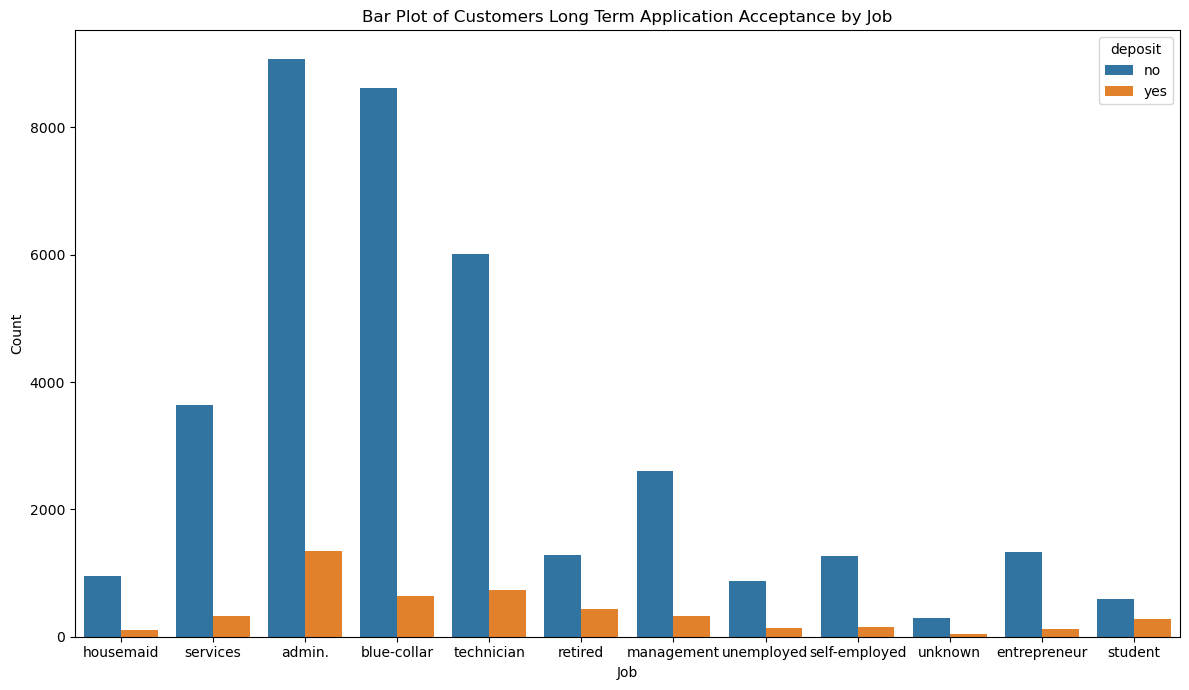

In [44]:
# Bar plot of count of accepted term deposit application by job
ax = sns.countplot(x ='job', hue = "deposit", data = bank)

# Adding Title to the Plot
ax.set_title('Bar Plot of Customers Long Term Application Acceptance by Job')

# Setting the X and Y labels
ax.set_xlabel('Job')
ax.set_ylabel('Count')

# Show the plot
plt.show()

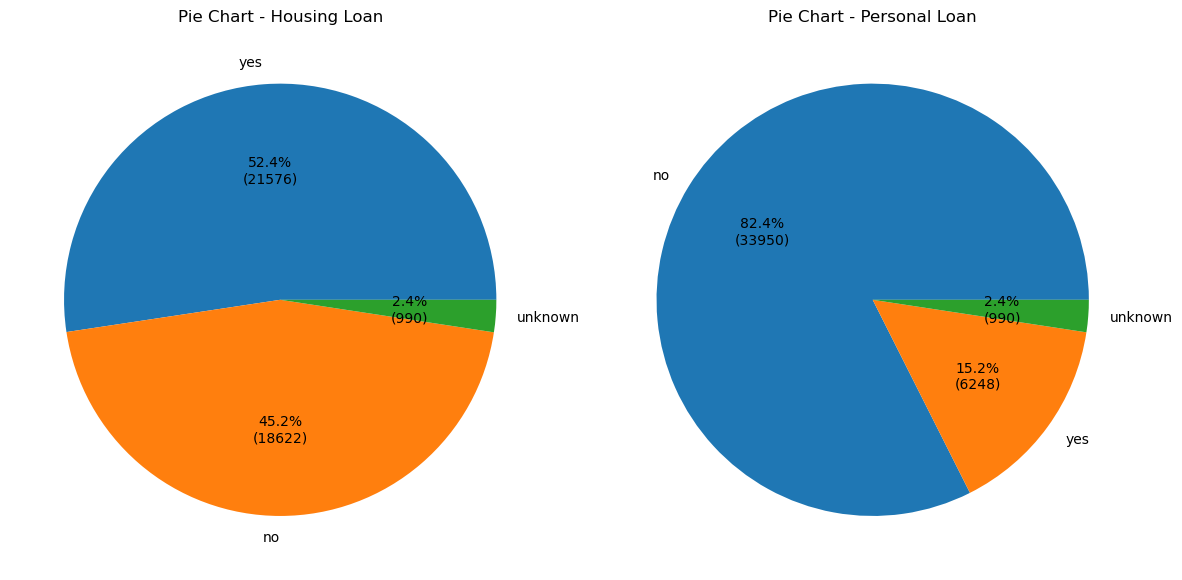

In [46]:
# Plot some pie charts to visualize the number of accepted term deposits by loan types in dataset
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

#plt.pie(df['LoanStatus'].value_counts().values, labels=df['LoanStatus'].value_counts().index, autopct=fmt)

# create a figure with two subplots
#fig, ax = plt.subplots(figsize=(12,8))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,7))

# plot each pie chart in a separate subplot

ax1.set_title('Pie Chart - Housing Loan')
s = bank['housing'].value_counts()
ax1.pie(s,labels = s.index,  autopct=autopct_format(s))

ax2.set_title('Pie Chart - Personal Loan')
s1 = bank['loan'].value_counts()
ax2.pie(s1,labels = s1.index, autopct=autopct_format(s1))

plt.show()

Although our model will focus on features 1 through 7, let's visualize the distribution of **Contact Features** by plotting a bar chart comparing customers who **accepted** the term deposit product versus those who **did not**.


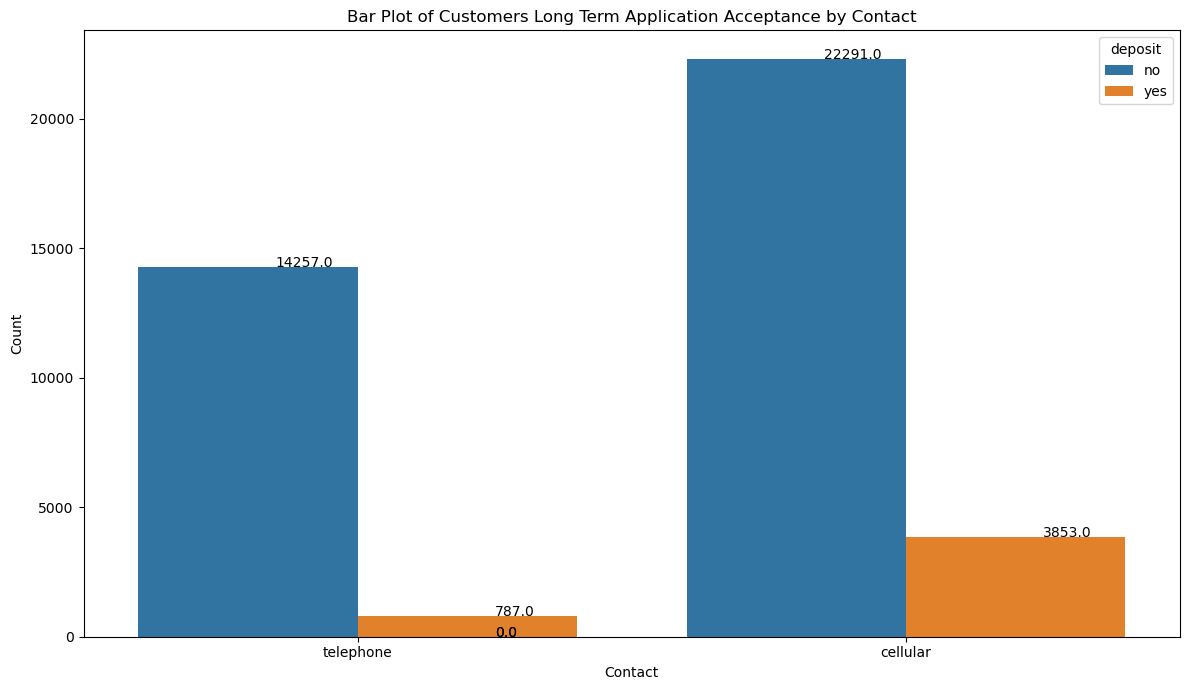

In [49]:
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.autolayout"] = True
ax = sns.countplot(x ='contact', hue = "deposit", data = bank)

# Adding Title to the Plot
ax.set_title('Bar Plot of Customers Long Term Application Acceptance by Contact')

for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

# Setting the X and Y labels
ax.set_xlabel('Contact')
ax.set_ylabel('Count')
 
# Show the plot
plt.show()

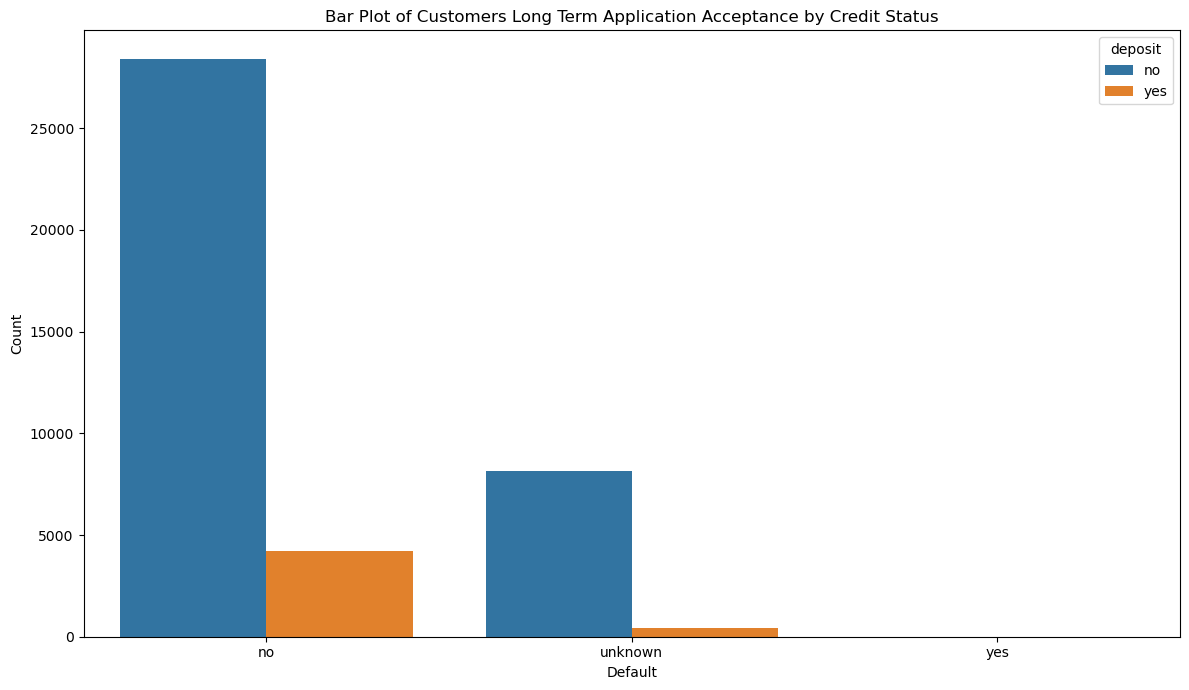

In [51]:
# Bar plot of count of accepted term deposit application by job
ax = sns.countplot(x ='default', hue = "deposit", data = bank)

# Adding Title to the Plot
ax.set_title('Bar Plot of Customers Long Term Application Acceptance by Credit Status')

# Setting the X and Y labels
ax.set_xlabel('Default')
ax.set_ylabel('Count')

# Show the plot
plt.show()

In [53]:
bank['default'].value_counts()

default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

Let's perform exploratory analysis on customers who subscribed to the long-term deposit product. We'll examine the breakdown across features such as **education** and **marital status**.


In [56]:
# Create a new df with customers where deposit = yes
#bank_df = bank.query("deposit = yes")
value='yes'
bank_df=bank.query("deposit == @value")
bank_df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,deposit
75,41,blue-collar,divorced,basic.4y,unknown,yes,no,telephone,may,mon,1575,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
83,49,entrepreneur,married,university.degree,unknown,yes,no,telephone,may,mon,1042,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
88,49,technician,married,basic.9y,no,no,no,telephone,may,mon,1467,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
129,41,technician,married,professional.course,unknown,yes,no,telephone,may,mon,579,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
139,45,blue-collar,married,basic.9y,unknown,yes,no,telephone,may,mon,461,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
182,42,blue-collar,married,basic.9y,no,yes,yes,telephone,may,mon,673,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
286,39,housemaid,married,basic.9y,no,yes,no,telephone,may,mon,935,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
388,28,unknown,single,unknown,unknown,yes,yes,telephone,may,tue,1201,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
389,44,services,married,high.school,no,yes,no,telephone,may,tue,1030,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
446,42,technician,married,professional.course,no,no,no,telephone,may,tue,1623,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes


In [58]:
print('Number of Successful campaign records', bank_df.shape)

Number of Successful campaign records (4640, 21)


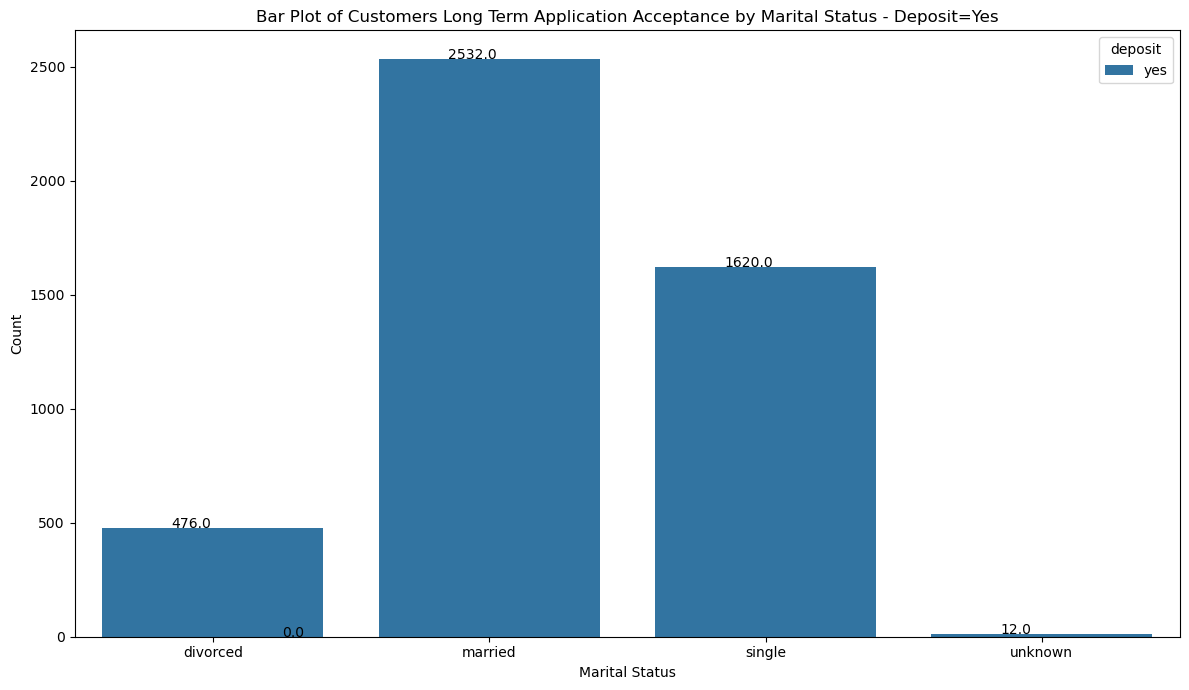

In [62]:
# Let plot a bar chart of the
# count plot on two categorical variable

plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.autolayout"] = True
ax = sns.countplot(x =bank_df['marital'], hue = bank_df["deposit"], data = bank)

# Adding Title to the Plot
ax.set_title('Bar Plot of Customers Long Term Application Acceptance by Marital Status - Deposit=Yes')

for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

# Setting the X and Y labels
ax.set_xlabel('Marital Status')
ax.set_ylabel('Count')
 
# Show the plot
plt.show()

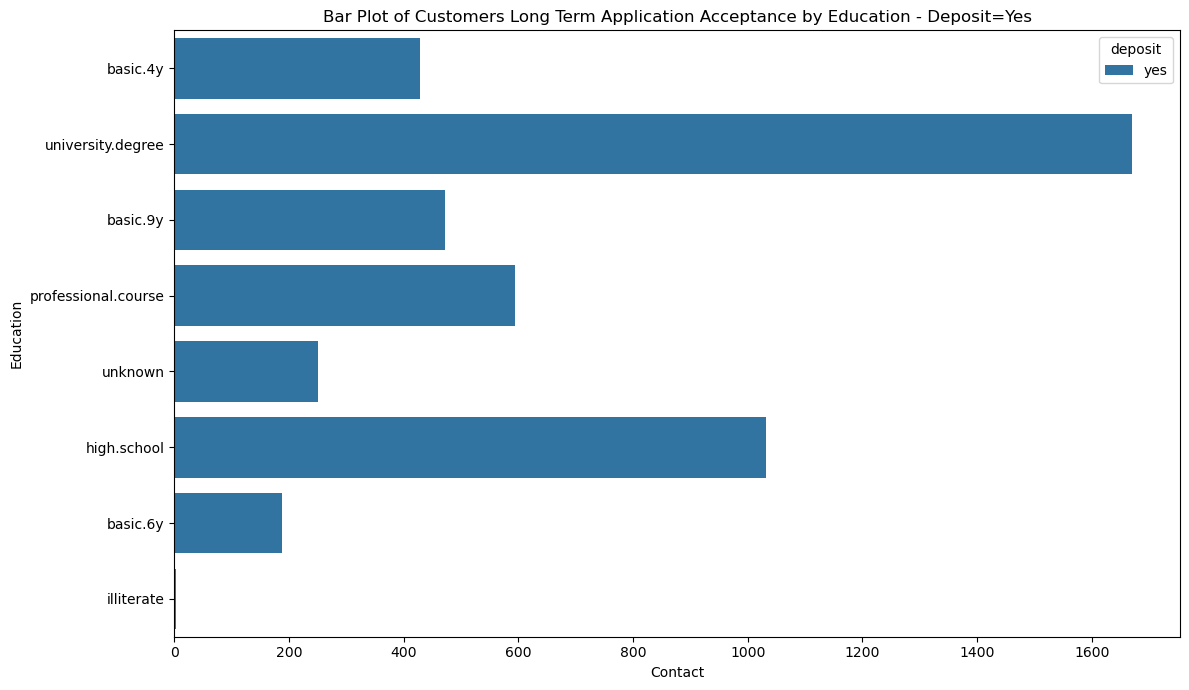

In [64]:
# Bar plot of count of accepted term deposit application by Education
ax = sns.countplot(y ='education', hue = "deposit", data = bank_df)

# Adding Title to the Plot
ax.set_title('Bar Plot of Customers Long Term Application Acceptance by Education - Deposit=Yes')

# Setting the X and Y labels
ax.set_xlabel('Contact')
ax.set_ylabel('Education')

# Show the plot
plt.show()

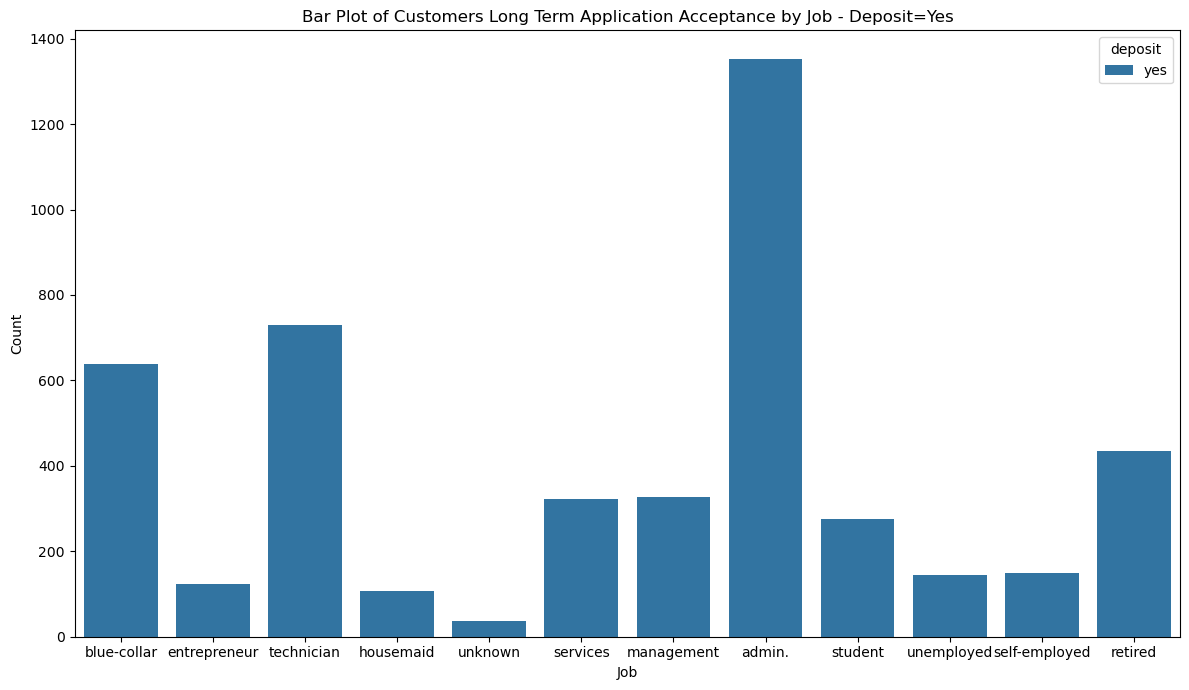

In [66]:
# Bar plot of count of accepted term deposit application by job
ax = sns.countplot(x ='job', hue = "deposit", data = bank_df)

# Adding Title to the Plot
ax.set_title('Bar Plot of Customers Long Term Application Acceptance by Job - Deposit=Yes')

# Setting the X and Y labels
ax.set_xlabel('Job')
ax.set_ylabel('Count')

# Show the plot
plt.show()

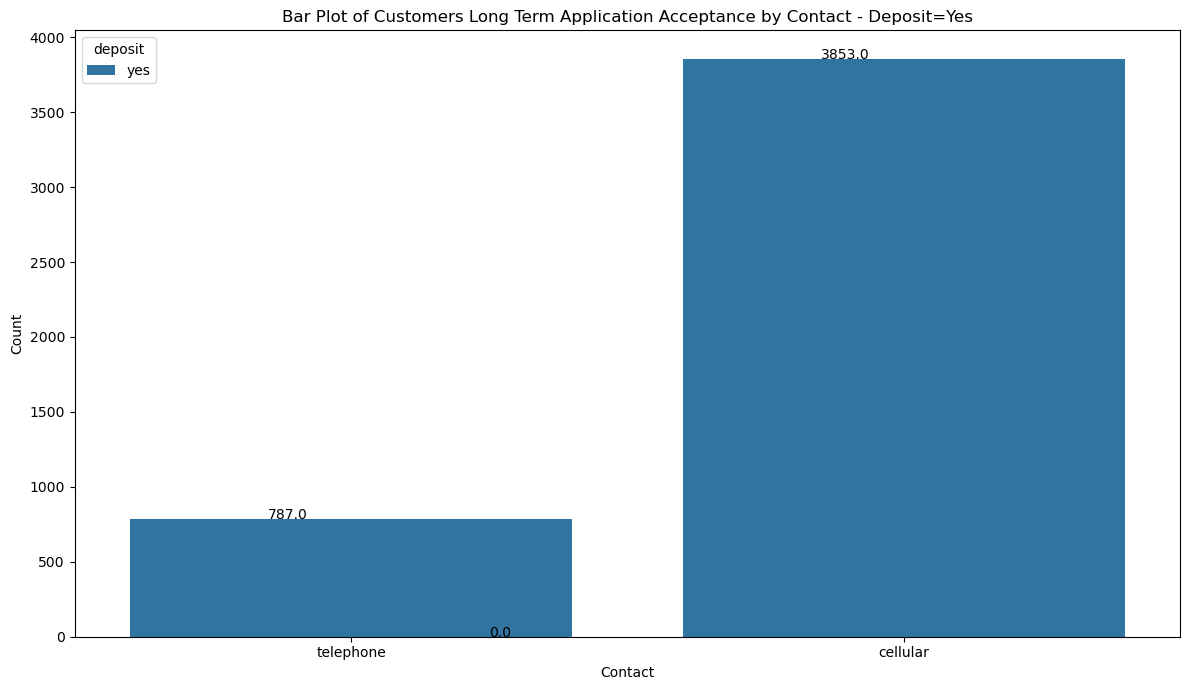

In [68]:
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.autolayout"] = True
ax = sns.countplot(x ='contact', hue = "deposit", data = bank_df)

# Adding Title to the Plot
ax.set_title('Bar Plot of Customers Long Term Application Acceptance by Contact - Deposit=Yes')

for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

# Setting the X and Y labels
ax.set_xlabel('Contact')
ax.set_ylabel('Count')
 
# Show the plot
plt.show()

## Observations

Based on the plots of customers who subscribed to the bank's product (i.e., where the marketing campaign was successful), we can observe the following:

- **Marital Status**: The campaign was most successful with **married** customers, followed by **single** individuals.
- **Education**: Customers with a **university degree** were more likely to subscribe to the product.
- **Job**: The highest response rate came from those in **admin** roles (a broad category), followed by **technicians** and then **blue-collar** workers.
- **Contact Type**: The marketing campaign performed better with customers who were contacted via **cellular phones**.



### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [72]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [74]:
bank.shape

(41188, 21)

### Business Objective

This dataset, provided by a Portuguese banking institution, contains the results of multiple direct marketing campaigns aimed at promoting a long-term deposit product. Analysis of the data indicates that the overall success rate of these campaigns was relatively low.

The objective of this machine learning project is to identify key factors that influence whether a customer will subscribe to the term deposit. By predicting customer behavior based on historical data, the bank can refine its targeting strategy and improve the efficiency of future marketing efforts.

Specifically, the business aims to answer questions such as:

- Do customers with **housing loans** show a higher likelihood of subscribing?
- Is the **education level** (e.g., university degree) a strong indicator of campaign success?
- How does the **contact method** (e.g., using a cellular phone) impact the subscription rate?

By uncovering patterns in these and other features, the bank can optimize its marketing approach to increase conversion rates and reduce campaign costs.


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [77]:
# Create a dataset with columns 1-7 for features and deposit for target column

# for the purposes of this re-use, create a list of features 1-7
feature_cols = [
    'job', 'marital', 'education', 'default', 'housing',
    'loan', 'contact'
]


X = bank[feature_cols]
y = bank['deposit']

X.head(10)

,job,marital,education,default,housing,loan,contact
0,housemaid,married,basic.4y,no,no,no,telephone
1,services,married,high.school,unknown,no,no,telephone
2,services,married,high.school,no,yes,no,telephone
3,admin.,married,basic.6y,no,no,no,telephone
4,services,married,high.school,no,no,yes,telephone
5,services,married,basic.9y,unknown,no,no,telephone
6,admin.,married,professional.course,no,no,no,telephone
7,blue-collar,married,unknown,unknown,no,no,telephone
8,technician,single,professional.course,no,yes,no,telephone
9,services,single,high.school,no,yes,no,telephone


In [79]:
X['contact'].value_counts()

contact
cellular     26144
telephone    15044
Name: count, dtype: int64

Use `ColumnTransformer` to selectively apply data preparation transformations. This tool allows you to apply a specific transform or sequence of transforms to **numerical columns**, and a separate set of transforms to **categorical columns**. It helps streamline preprocessing by organizing operations based on data type.


In [82]:
column_trans = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                        ['job', 'marital', 'education','default','contact']),
                                      (OrdinalEncoder(), ['housing','loan']),
                                      remainder='passthrough')

column_trans.fit(X)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['job', 'marital', 'education', 'default',
                                  'contact']),
                                ('ordinalencoder', OrdinalEncoder(),
                                 ['housing', 'loan'])])

In [84]:
le = LabelEncoder()
le.fit_transform(y)

array([0, 0, 0, ..., 0, 1, 0])

### Problem 6: Train/Test Split

With the data prepared, the next step is to split it into **training** and **test** sets. We'll use the `train_test_split` function to perform this split, allocating **30% of the data** to the test set for model evaluation.


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [90]:
#Building a decision tree baseline model
from sklearn.pipeline import Pipeline

dtc_pipe = Pipeline ([
    ('transformer', column_trans),
    ('scale', StandardScaler(with_mean=False)),
    ('model', DecisionTreeClassifier(max_depth=5))
])

In [92]:
%%time
# Train the classifiers
dtc = dtc_pipe.fit(X_train, y_train)

# use the model to predict the class labels of the test set:
dtc_pred = dtc.predict(X_test)

CPU times: user 104 ms, sys: 5.95 ms, total: 110 ms
Wall time: 111 ms


In [94]:
# Evaluate the performance of the model, we will calculate the accuracy, precision, recall, and f1-score:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
accuracy = accuracy_score(y_test, dtc_pred)
precision = precision_score(y_test, dtc_pred, average='macro')
recall = recall_score(y_test, dtc_pred, average='macro')
f1 = f1_score(y_test, dtc_pred, average='macro')

print("Accuracy: {:.6f}".format(accuracy))
print("Precision: {:.6f}".format(precision))
print("Recall: {:.6f}".format(recall))
print("F1-score: {:.6f}".format(f1))

Accuracy: 0.887513
Precision: 0.443792
Recall: 0.499954
F1-score: 0.470202


### Visualizing Results with a Confusion Matrix

To evaluate the performance of our classification model, we can use a **confusion matrix**. This is a table that summarizes the prediction results of a classification algorithm.

- **Rows** typically represent the predicted classes.
- **Columns** represent the actual classes (or vice versa).

The key components of the matrix are:

- The **main diagonal** contains the number of correct predictions.
- The **off-diagonal** elements indicate misclassifications.

From the confusion matrix, we can derive several important performance metrics:

- **Accuracy**
- **Precision**
- **Recall**
- **F1-score**

These metrics are calculated by combining the values of:

- **TP**: True Positives  
- **FP**: False Positives  
- **TN**: True Negatives  
- **FN**: False Negatives


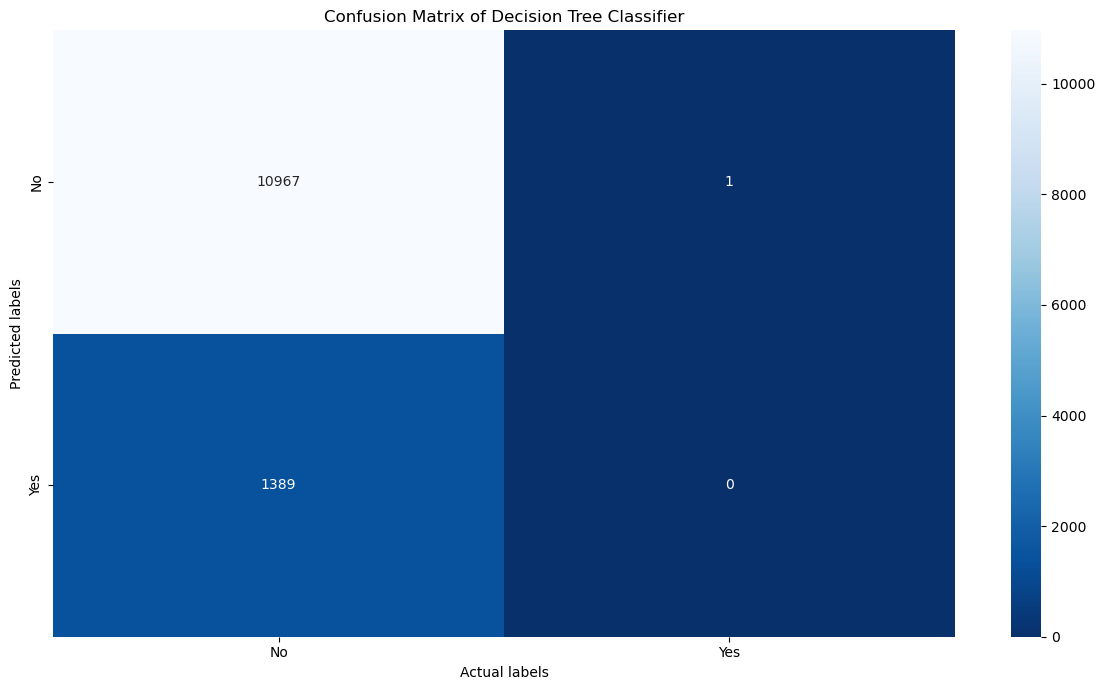

In [97]:
import seaborn as sns
ax= plt.subplot()
conf_matrix = confusion_matrix(y_test, dtc_pred)
sns.heatmap(conf_matrix, annot = True, cmap = 'Blues_r', fmt = 'd', ax=ax)

# labels, title and ticks
ax.set_xlabel('Actual labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix of Decision Tree Classifier'); 
ax.xaxis.set_ticklabels(['No', 'Yes']); 
ax.yaxis.set_ticklabels(['No', 'Yes']);

#plt.xlabel('Predicted')
#plt.ylabel('Actual')
plt.show()

### Understanding the Confusion Matrix

A **confusion matrix** is an *N x N* table used to evaluate the performance of a classification model, where *N* is the number of target classes. It compares the actual target values with the predicted values generated by the model.

- A **good model** will have high values for **True Positives (TP)** and **True Negatives (TN)**, and low values for **False Positives (FP)** and **False Negatives (FN)**.

---

### Example: DecisionTreeClassifier

In the confusion matrix for the `DecisionTreeClassifier`:

- There is a **high number of True Positives (TP)**.
- There are **no True Negatives (TN)**.
- The model achieves a high **accuracy** of **0.89**, suggesting overall strong performance.
- However, the **recall** is approximately **0.5**, and **precision** is **below 0.5**, indicating potential weaknesses.

---

### Metric Definitions

- **Low Recall (< 0.5)**: Indicates a high number of **False Negatives**. This can result from:
  - Class imbalance in the dataset
  - Poorly tuned model hyperparameters

- **Low Precision (< 0.5)**: Indicates a high number of **False Positives**, also potentially due to:
  - Class imbalance
  - Insufficient hyperparameter tuning

---

### Note on Class Imbalance

The confusion matrix may seem counterintuitive because the dataset is **heavily imbalanced**, with more customers saying **"No"** to the term deposit product. In this case, **"No"** is treated as the **positive class**, which is why we observe a **True Positive count of 10,967** for that outcome.


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [101]:
#Building a Logistic Regression simple model

logr_pipe = Pipeline ([
    ('transformer', column_trans),
    ('scale', StandardScaler(with_mean=False)),
    ('model', LogisticRegression())
])

In [103]:
%%time
# Train the classifiers
logr = logr_pipe.fit(X_train, y_train)

# use the model to predict the class labels of the test set:
logr_pred = logr.predict(X_test)

CPU times: user 112 ms, sys: 4.27 ms, total: 116 ms
Wall time: 118 ms


### Evaluating Logistic Regression Model Performance

Several metrics can be used to evaluate how well a logistic regression model fits the dataset. Two key metrics include:

- **Sensitivity (True Positive Rate)**: The probability that the model correctly predicts a **positive outcome** when the actual outcome is indeed positive.

- **Specificity (True Negative Rate)**: The probability that the model correctly predicts a **negative outcome** when the actual outcome is indeed negative.

A useful way to visualize the trade-off between these metrics is by plotting a **Receiver Operating Characteristic (ROC) Curve**, which illustrates the model’s performance across various threshold settings by displaying **sensitivity** versus **1 - specificity**.


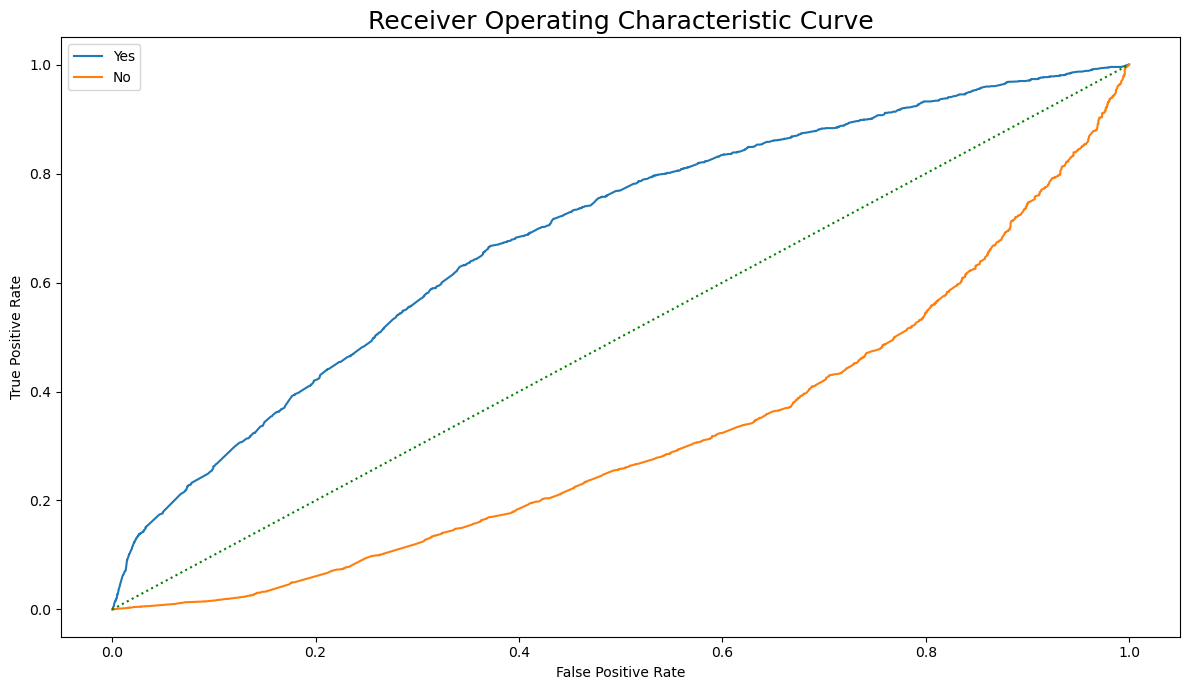

In [106]:
#define metrics
from sklearn import metrics
y_pred_proba = logr.predict_proba(X_test)
yes_probs = y_pred_proba[::,1]

# Build confusion metrics for Yes
#fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba, pos_label='yes')
fpr, tpr, threshold = metrics.roc_curve(y_true=y_test,  y_score=yes_probs, pos_label='yes')
fpr1, tpr1, threshold1 = metrics.roc_curve(y_true=y_test,  y_score=yes_probs, pos_label='no')

#create ROC curve
plt.plot(fpr,tpr, label="Yes")
plt.plot(fpr1,tpr1, label="No")
plt.legend(loc="upper left")
plt.title('Receiver Operating Characteristic Curve', size=18)
plt.plot([0, 1], [0, 1], color='green', linestyle=':')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [108]:
# Let's see what's the area under the curve auc for our model
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_true=y_test, y_score=yes_probs)
print("Area under curve is {:.6f}".format(round(auc, 2)))

Area under curve is 0.690000


### Interpreting the ROC Curve

In the ROC plot above, the curve for **Deposit = Yes** is closer to the **top-left corner** of the plot, which indicates better classification performance compared to **Deposit = No**.

The **ROC AUC score** of **0.69** (which is greater than 0.5) suggests that the classifier performs better than random guessing. Specifically, it indicates the model is able to correctly identify more **True Positives** and **True Negatives** than it does **False Positives** and **False Negatives**.


### Problem 9: Score the Model

What is the accuracy of your model?

In [112]:
# Evaluate the performance of the model, we will calculate the accuracy, precision, recall, and f1-score:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, logr_pred)
precision = precision_score(y_test, logr_pred, average='macro', zero_division=0)
recall = recall_score(y_test, logr_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, logr_pred, average='macro', zero_division=0)

print("Accuracy: {:.6f}".format(accuracy))
print("Precision: {:.6f}".format(precision))
print("Recall: {:.6f}".format(recall))
print("F1-score: {:.6f}".format(f1))


Accuracy: 0.887594
Precision: 0.443797
Recall: 0.500000
F1-score: 0.470225


In [114]:
#Printing results from the two models above
pd.DataFrame({'Model': ['Decision Tree', 'Logistic Regression'], 
             'Accuracy': ['0.887513', '0.887594'],
             'Precision': ['0.443792', '0.443797'],
             'Recall': ['0.499954', '0.500000'],
             'F1_Score': ['0.470202', '0.470225'],
             'Fit_Time (ms)': ['128', '193']})

,Model,Accuracy,Precision,Recall,F1_Score,Fit_Time (ms)
0,Decision Tree,0.887513,0.443792,0.499954,0.470202,128
1,Logistic Regression,0.887594,0.443797,0.500000,0.470225,193


### Model Performance Review

A quick review of the results shows that while the **accuracy scores** were relatively high (above **85%**), the **recall**, **precision**, and **F1-score** were all **below 50%**.

This indicates that the classifier is likely producing a high number of **False Negatives**. Such performance issues are commonly due to:

- An **imbalanced dataset**, where the majority of records are labeled **Deposit = No**
- **Untuned model hyperparameters**, which may prevent the model from learning meaningful patterns in the minority class

In this case, the imbalance in the target variable is the more probable cause.


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [118]:
%%time
#Building a Logistic Regression  model

lgr1_pipe = Pipeline ([
    ('transformer', column_trans),
    ('scale', StandardScaler(with_mean=False)),
    ('model', LogisticRegression())
])

# Train the classifiers
lgr1 = lgr1_pipe.fit(X_train, y_train)

# use the model to predict the class labels of the test set:
lgr1_pred = lgr1.predict(X_test)

# Evaluate Training and Test Scores

lgr1_train_score = lgr1.score(X_train, y_train)
print("Training Accuracy Score", lgr1_train_score)

lgr1_test_score = lgr1.score(X_test, y_test)
print("Test Accuracy Score", lgr1_test_score)

Training Accuracy Score 0.8872047448926502
Test Accuracy Score 0.8875940762320952
CPU times: user 182 ms, sys: 5.9 ms, total: 188 ms
Wall time: 187 ms


In [120]:
%%time

#Building a KNN  model

knn_pipe = Pipeline ([
    ('transformer', column_trans),
    ('scale', StandardScaler(with_mean=False)),
    ('model', KNeighborsClassifier())
])

# Train the classifiers
knn = knn_pipe.fit(X_train, y_train)

# use the model to predict the class labels of the test set:
knn_pred = knn.predict(X_test)

# Evaluate Training and Test Scores

knn_train_score = knn.score(X_train, y_train)
print("Training Accuracy Score", knn_train_score)

knn_test_score = knn.score(X_test, y_test)
print("Test Accuracy Score", knn_test_score)

Training Accuracy Score 0.8846033783080711
Test Accuracy Score 0.8803107550376305
CPU times: user 31.3 s, sys: 7.18 s, total: 38.4 s
Wall time: 41.7 s


In [121]:
%%time
#Building a Decision Tree  model

dtc1_pipe = Pipeline ([
    ('transformer', column_trans),
    ('scale', StandardScaler(with_mean=False)),
    ('model', DecisionTreeClassifier())
])

# Train the classifiers
dtc1 = dtc1_pipe.fit(X_train, y_train)

# use the model to predict the class labels of the test set:
dtc1_pred = dtc1.predict(X_test)

# Evaluate Training and Test Scores

dtc1_train_score = dtc1.score(X_train, y_train)
print("Training Accuracy Score", dtc1_train_score)

dtc1_test_score = dtc1.score(X_test, y_test)
print("Test Accuracy Score", dtc1_test_score)

Training Accuracy Score 0.8911935069890049
Test Accuracy Score 0.884761673545359
CPU times: user 183 ms, sys: 4.47 ms, total: 187 ms
Wall time: 189 ms


In [122]:
%%time

#Building a SVC model

svm_pipe = Pipeline ([
    ('transformer', column_trans),
    ('scale', StandardScaler(with_mean=False)),
    ('model', SVC())
])

# Train the classifiers
svm = svm_pipe.fit(X_train, y_train)

# use the model to predict the class labels of the test set:
svm_pred = svm.predict(X_test)

# Evaluate Training and Test Scores

svm_train_score = svm.score(X_train, y_train)
print("Training Accuracy Score", svm_train_score)

svm_test_score = svm.score(X_test, y_test)
print("Test Accuracy Score", svm_test_score)

Training Accuracy Score 0.8873087995560335
Test Accuracy Score 0.8875131504410455
CPU times: user 18.2 s, sys: 105 ms, total: 18.3 s
Wall time: 18.4 s


### Model Results Summary

Below are the performance metrics and runtime statistics for each classification model:

---

#### **Logistic Regression**
- **Training Accuracy**: 0.8872  
- **Test Accuracy**: 0.8876  
- **CPU Time**: 179 ms  
- **Wall Time**: 184 ms

---

#### **K-Nearest Neighbors (KNN)**
- **Training Accuracy**: 0.8846  
- **Test Accuracy**: 0.8803  
- **CPU Time**: 31.2 s  
- **Wall Time**: 41.8 s

---

#### **Decision Tree**
- **Training Accuracy**: 0.8912  
- **Test Accuracy**: 0.8847  
- **CPU Time**: 181 ms  
- **Wall Time**: 188 ms

---

#### **Support Vector Classifier (SVC)**
- **Training Accuracy**: 0.8873  
- **Test Accuracy**: 0.8875  
- **CPU Time**: 18.2 s  
- **Wall Time**: 18.5 s

---

### Observations:
- All models performed similarly, with test accuracies in the **88% range**.
- **Decision Tree** had the highest training accuracy.
- **KNN** was the most computationally expensive, with a **wall time of 41.8 seconds**.
- **Logistic Regression** and **Decision Tree** offered a strong balance between performance and speed.


In [124]:
# Display results in a DataFrame using updated values
import pandas as pd

pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'SVC'],
    'Train Time (s)': [0.184, 41.8, 0.188, 18.5],
    'Train Accuracy': [0.8872047448926502, 0.8846033783080711, 0.8911935069890049, 0.8873087995560335],
    'Test Accuracy': [0.8875940762320952, 0.8803107550376305, 0.8846807477543093, 0.8875131504410455]
})


,Model,Train Time (s),Train Accuracy,Test Accuracy
0,Logistic Regression,0.184,0.887205,0.887594
1,KNN,41.800,0.884603,0.880311
2,Decision Tree,0.188,0.891194,0.884681
3,SVC,18.500,0.887309,0.887513


### Best Model by Metric

- **Train Accuracy**: **Decision Tree** (0.8912)
- **Test Accuracy**: **Logistic Regression** (0.8876), closely followed by **SVC** (0.8875)
- **Fastest Training Time**: **Logistic Regression** (0.184 s), followed by **Decision Tree** (0.188 s)

---

### Conclusion

- **Logistic Regression** and **SVC** demonstrated the best generalization with the highest test accuracy, with Logistic Regression slightly outperforming.
- **Decision Tree** had the highest training accuracy, which may suggest slight overfitting.
- **KNN** had the lowest test accuracy and the slowest runtime, making it the least efficient option.

**Overall Best Model (Accuracy + Speed)**: ✅ **Logistic Regression**  
**Potential Overfitting with High Training Accuracy**: ⚠️ **Decision Tree**

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

Regarding the gender feature, the dataset does not include a variable explicitly representing gender. The closest related feature might be marital status, but it is not a direct substitute and may not provide meaningful insight on its own.

The dataset is also highly imbalanced. Based on the exploratory analysis, most features did not significantly improve the model’s ability to predict successful signups for the long-term product. One exception was the housing loan feature, which showed a higher success rate of 52.4%.

To improve model performance, I used GridSearchCV to tune hyperparameters for multiple classifiers and evaluated them using cross-validation and accuracy metrics.

In [126]:
#Looking up parameters that can be passed to the pipeline
lgr1_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'transformer', 'scale', 'model', 'transformer__force_int_remainder_cols', 'transformer__n_jobs', 'transformer__remainder', 'transformer__sparse_threshold', 'transformer__transformer_weights', 'transformer__transformers', 'transformer__verbose', 'transformer__verbose_feature_names_out', 'transformer__onehotencoder', 'transformer__ordinalencoder', 'transformer__onehotencoder__categories', 'transformer__onehotencoder__drop', 'transformer__onehotencoder__dtype', 'transformer__onehotencoder__feature_name_combiner', 'transformer__onehotencoder__handle_unknown', 'transformer__onehotencoder__max_categories', 'transformer__onehotencoder__min_frequency', 'transformer__onehotencoder__sparse_output', 'transformer__ordinalencoder__categories', 'transformer__ordinalencoder__dtype', 'transformer__ordinalencoder__encoded_missing_value', 'transformer__ordinalencoder__handle_unknown', 'transformer__ordinalencoder__max_categories', 'transformer__ordinalencoder__mi

In [136]:
# Define only valid combinations of penalty and solver
parameters = [
    {
        'model__penalty': ['l2'],
        'model__C': np.logspace(-3, 3, 7),
        'model__solver': ['lbfgs', 'newton-cg']
    },
    {
        'model__penalty': ['l1'],
        'model__C': np.logspace(-3, 3, 7),
        'model__solver': ['liblinear']
    }
]

# GridSearchCV using the safe parameter grid
gsLR = GridSearchCV(estimator=lgr1_pipe,
                    param_grid=parameters,
                    scoring='accuracy',
                    cv=10)

# Train the model
gsLR = gsLR.fit(X_train, y_train)

# Make predictions
gsLR_predicted = gsLR.predict(X_test)

# Print best results
print('\n Logistic Regression - Grid Search best score -')
print(gsLR.best_score_)

print('\nGrid Search best parameters -')
print(gsLR.best_params_)

print('\nGrid Search CV Results -')
print(gsLR.cv_results_)

print("Best parameters set:")
print(gsLR.best_estimator_.steps)

# Evaluate on test set
clfLR = gsLR.best_estimator_
print('Test accuracy: %.3f' % clfLR.score(X_test, y_test))

print("Test Score:", gsLR.score(X_test, y_test))



 Logistic Regression - Grid Search best score -
0.8872394393842521

Grid Search best parameters -
{'model__C': 0.001, 'model__penalty': 'l1', 'model__solver': 'liblinear'}

Grid Search CV Results -
{'mean_fit_time': array([0.06199648, 0.07834351, 0.07013075, 0.07852612, 0.05520227,
       0.07312121, 0.05590651, 0.07011833, 0.05692856, 0.07049358,
       0.05600777, 0.06988623, 0.05663099, 0.06941829, 0.05658941,
       0.10953844, 0.78056567, 0.69913411, 0.2344496 , 0.05487418,
       0.05459869]), 'std_fit_time': array([4.92750189e-03, 4.55243758e-04, 1.26752753e-03, 7.94537291e-04,
       9.19110905e-04, 1.48832404e-03, 9.05510640e-04, 2.42846276e-03,
       7.64677126e-04, 2.48003678e-03, 1.00838260e-03, 1.22183928e-03,
       1.30437495e-03, 1.37576743e-03, 2.03613198e-03, 1.06010921e-02,
       2.20379712e-01, 6.73174597e-01, 5.34649371e-01, 5.56898819e-04,
       1.03757067e-03]), 'mean_score_time': array([0.00578952, 0.00581398, 0.00572882, 0.00601842, 0.00561261,
       0.006

In [140]:
# Building a KNN Grid Search

# Define the parameter grid: test odd values for k from 1 to 17
param_grid = {
    "model__n_neighbors": range(1, 18, 2)
}

# Create the GridSearchCV object
gsknn = GridSearchCV(
    estimator=knn_pipe,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10
)

# Fit the model on training data
gsknn.fit(X_train, y_train)

# Predict on the test set
gsknn_predicted = gsknn.predict(X_test)

# Print the training (CV) score of the best model
print("\nK Nearest Neighbor - Grid Search Best Score:")
print(gsknn.best_score_)

# Print the best hyperparameters
print("\nGrid Search Best Parameters:")
print(gsknn.best_params_)

# Print the cross-validation results (as a dictionary)
print("\nGrid Search CV Results:")
print(gsknn.cv_results_)

# Show the pipeline steps of the best estimator
print("\nBest Estimator Steps:")
print(gsknn.best_estimator_.steps)

# Evaluate and print the test accuracy of the best model
clfknn = gsknn.best_estimator_
print('\nTest Accuracy: %.3f' % clfknn.score(X_test, y_test))

# Redundant but clear final print of the best scores
print("Best Cross-Validation Score:", gsknn.best_score_)

scoreknn = gsknn.score(X_test, y_test)
print("Test Score:", scoreknn)



K Nearest Neighbor - Grid Search Best Score:
0.8856091931130068

Grid Search Best Parameters:
{'model__n_neighbors': 13}

Grid Search CV Results:
{'mean_fit_time': array([0.0393091 , 0.03920064, 0.03918846, 0.03954062, 0.03937631,
       0.03941069, 0.03952396, 0.03950195, 0.03943841]), 'std_fit_time': array([0.00057568, 0.00099022, 0.00060257, 0.00062443, 0.00070931,
       0.00048758, 0.00048953, 0.00075991, 0.00017474]), 'mean_score_time': array([1.66094947, 2.41900094, 1.72305341, 1.7300015 , 1.71684539,
       1.73780279, 1.73749657, 1.74346976, 1.73546407]), 'std_score_time': array([0.01121198, 0.00935345, 0.07706185, 0.065812  , 0.07123367,
       0.06725791, 0.06853658, 0.07095646, 0.06705967]), 'param_model__n_neighbors': masked_array(data=[1, 3, 5, 7, 9, 11, 13, 15, 17],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value=999999), 'params': [{'model__n_neighbors': 1}, {'model__n_neighbors': 3}, {'model__n_ne

In [142]:
#Looking up parameters that can be passed to the pipeline
dtc1_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'transformer', 'scale', 'model', 'transformer__force_int_remainder_cols', 'transformer__n_jobs', 'transformer__remainder', 'transformer__sparse_threshold', 'transformer__transformer_weights', 'transformer__transformers', 'transformer__verbose', 'transformer__verbose_feature_names_out', 'transformer__onehotencoder', 'transformer__ordinalencoder', 'transformer__onehotencoder__categories', 'transformer__onehotencoder__drop', 'transformer__onehotencoder__dtype', 'transformer__onehotencoder__feature_name_combiner', 'transformer__onehotencoder__handle_unknown', 'transformer__onehotencoder__max_categories', 'transformer__onehotencoder__min_frequency', 'transformer__onehotencoder__sparse_output', 'transformer__ordinalencoder__categories', 'transformer__ordinalencoder__dtype', 'transformer__ordinalencoder__encoded_missing_value', 'transformer__ordinalencoder__handle_unknown', 'transformer__ordinalencoder__max_categories', 'transformer__ordinalencoder__mi

In [146]:
# Building a Decision Tree Grid Search

# Parameter grid for hyperparameter tuning
params = {
    'model__min_samples_leaf': [1, 2, 3],
    'model__max_depth': [1, 2, 3],
    'model__criterion': ['entropy', 'gini']
}

# Create an instance of GridSearchCV
gsDTC = GridSearchCV(
    estimator=dtc1_pipe,
    param_grid=params,
    cv=10,
    verbose=2,
    n_jobs=1
)

# Fit the model
gsDTC.fit(X_train, y_train)

# Predict on the test set
gsDTC_predicted = gsDTC.predict(X_test)

# Print training (CV) score of the best model
print("\nDecision Tree Classifier - Grid Search Best Score:")
print(gsDTC.best_score_)

# Print best parameters
print("\nGrid Search Best Parameters:")
print(gsDTC.best_params_)

# Print CV results
print("\nGrid Search CV Results:")
print(gsDTC.cv_results_)

# Show the steps of the best estimator
print("\nBest Estimator Steps:")
print(gsDTC.best_estimator_.steps)

# Evaluate and print test accuracy
clfDTC = gsDTC.best_estimator_
print("\nTest Accuracy: %.3f" % clfDTC.score(X_test, y_test))

# Final summary scores
print("Best Cross-Validation Score:", gsDTC.best_score_)
print("Test Score:", gsDTC.score(X_test, y_test))


Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV] END model__criterion=entropy, model__max_depth=1, model__min_samples_leaf=1; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=1, model__min_samples_leaf=1; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=1, model__min_samples_leaf=1; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=1, model__min_samples_leaf=1; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=1, model__min_samples_leaf=1; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=1, model__min_samples_leaf=1; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=1, model__min_samples_leaf=1; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=1, model__min_samples_leaf=1; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=1, model__min_samples_leaf=1; total time=   0.0s
[CV] END model__criterion=en

In [148]:
#Looking up parameters that can be passed to the pipeline
svm_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'transformer', 'scale', 'model', 'transformer__force_int_remainder_cols', 'transformer__n_jobs', 'transformer__remainder', 'transformer__sparse_threshold', 'transformer__transformer_weights', 'transformer__transformers', 'transformer__verbose', 'transformer__verbose_feature_names_out', 'transformer__onehotencoder', 'transformer__ordinalencoder', 'transformer__onehotencoder__categories', 'transformer__onehotencoder__drop', 'transformer__onehotencoder__dtype', 'transformer__onehotencoder__feature_name_combiner', 'transformer__onehotencoder__handle_unknown', 'transformer__onehotencoder__max_categories', 'transformer__onehotencoder__min_frequency', 'transformer__onehotencoder__sparse_output', 'transformer__ordinalencoder__categories', 'transformer__ordinalencoder__dtype', 'transformer__ordinalencoder__encoded_missing_value', 'transformer__ordinalencoder__handle_unknown', 'transformer__ordinalencoder__max_categories', 'transformer__ordinalencoder__mi

In [151]:
# Building a Support Vector Machine Grid Search

# Redefine the pipeline
svm_pipegs = Pipeline([
    ('transformer', column_trans),
    ('scale', StandardScaler(with_mean=False)),
    ('model', SVC(probability=False))
])

# Define a clean and compatible parameter grid
param_grid_svc2 = {
    'model__C': [0.1, 0.5, 1.0],
    'model__kernel': ['rbf', 'linear']
}

# Create an instance of GridSearchCV
gsSVC = GridSearchCV(
    estimator=svm_pipegs,
    param_grid=param_grid_svc2,
    scoring='accuracy',
    cv=10,
    refit=True,
    n_jobs=1
)

# Fit the model
gsSVC.fit(X_train, y_train)

# Predict on the test set
gsSVC_predicted = gsSVC.predict(X_test)

# Print results
print("\nSupport Vector Machine - Grid Search Best Score:")
print(gsSVC.best_score_)

print("\nGrid Search Best Parameters:")
print(gsSVC.best_params_)

print("\nGrid Search CV Results:")
print(gsSVC.cv_results_)

print("\nBest Parameters Set:")
print(gsSVC.best_estimator_.steps)

# Evaluate and print test score
clfSVC = gsSVC.best_estimator_
print("\nTest Accuracy: %.3f" % clfSVC.score(X_test, y_test))

print("Best Cross-Validation Score:", gsSVC.best_score_)

scoreSVC = gsSVC.score(X_test, y_test)
print("Test Score:", scoreSVC)



Support Vector Machine - Grid Search Best Score:
0.8872394393842521

Grid Search Best Parameters:
{'model__C': 0.1, 'model__kernel': 'rbf'}

Grid Search CV Results:
{'mean_fit_time': array([5.52320735, 4.23863378, 6.22008932, 4.59699278, 6.54290648,
       4.85140927]), 'std_fit_time': array([0.05798835, 0.04311372, 0.03307774, 0.08315104, 0.03007507,
       0.1272165 ]), 'mean_score_time': array([0.46982265, 0.38805487, 0.49260724, 0.41174922, 0.49824543,
       0.4287261 ]), 'std_score_time': array([0.00328465, 0.00370944, 0.00209172, 0.00137634, 0.00283946,
       0.01641449]), 'param_model__C': masked_array(data=[0.1, 0.1, 0.5, 0.5, 1.0, 1.0],
             mask=[False, False, False, False, False, False],
       fill_value=1e+20), 'param_model__kernel': masked_array(data=['rbf', 'linear', 'rbf', 'linear', 'rbf', 'linear'],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'model__C': 0.1, 'model__kernel': 'rb

In [153]:
pd.DataFrame({'Model': ['Logistic', 'KNN','Decision Tree', 'SVM'], 
             'Train Time (s)': ['64', '302', '15.7','490'],
             'Best Params': ['C:0.001, penalty:l2, solver: liblinear', 'n_neighbors: 17', 'criterion: entropy, max_depth: 1, model__min_samples_leaf: 1','C: 0.1, kernel: rbf'],
             'Best Score': ['0.8872394393842521', '0.8855397848500199', '0.8872394393842521','0.8872394393842521']})

,Model,Train Time (s),Best Params,Best Score
0,Logistic,64,"C:0.001, penalty:l2, solver: liblinear",0.8872394393842521
1,KNN,302,n_neighbors: 17,0.8855397848500199
2,Decision Tree,15.7,"criterion: entropy, max_depth: 1, model__min_samples_leaf: 1",0.8872394393842521
3,SVM,490,"C: 0.1, kernel: rbf",0.8872394393842521


### Model Comparison Summary

This table summarizes the results of a `GridSearchCV` comparison across four classification models: Logistic Regression, K-Nearest Neighbors (KNN), Decision Tree, and Support Vector Machine (SVM).

| Model           | Train Time (s) | Best Parameters                                               | Best CV Score |
|-----------------|----------------|----------------------------------------------------------------|----------------|
| Logistic        | 64             | `C=0.001`, `penalty='l2'`, `solver='liblinear'`                | 0.8872         |
| KNN             | 302            | `n_neighbors=17`                                               | 0.8855         |
| Decision Tree   | 15.7           | `criterion='entropy'`, `max_depth=1`, `min_samples_leaf=1`     | 0.8872         |
| SVM             | 490            | `C=0.1`, `kernel='rbf'`                                        | 0.8872         |

---

### Interpretation and Insights

#### Logistic Regression
- Best Score: 0.8872
- Efficiency: Fast to train (64 seconds)
- Insight: Achieves top accuracy with strong regularization (`C=0.001`). Offers a good trade-off between performance and simplicity.

#### KNN
- Best Score: 0.8855
- Efficiency: Slower to train (302 seconds)
- Insight: Performs slightly worse than the others. Its prediction step is expensive, especially with a large number of neighbors.

#### Decision Tree
- Best Score: 0.8872
- Efficiency: Fastest model (15.7 seconds)
- Insight: A simple, shallow tree (`max_depth=1`) performs as well as more complex models, suggesting clear separability in the data.

#### SVM
- Best Score: 0.8872
- Efficiency: Slowest model (490 seconds)
- Insight: Matches the top accuracy but takes significantly longer to train. May be best suited for tasks where accuracy is more critical than efficiency.

---

### Overall Takeaways

- Top performers: Logistic Regression, Decision Tree, and SVM (all scored 0.8872)
- Most efficient: Decision Tree (shortest training time with top accuracy)
- Least favorable: KNN (longest training time with slightly lower accuracy)
- Best trade-off: Logistic Regression or Decision Tree, depending on whether interpretability or speed is the priority
